In [1]:
import os
os.chdir("..")

In [2]:
from src.data.data_process import DataReg
import polars as pl
import arviz as az
import matplotlib.dates as mdates
import numpy as np
import geopandas as gpd
import causalpy as cp
import pandas as pd
import arviz as az
import bambi as bmb
from shapely import wkt
import matplotlib.pyplot as plt
dr = DataReg()

In [3]:
df = dr.conn.sql("SELECT first_month_employment, second_month_employment, third_month_employment, ui_addr_5_zip, qtr, year FROM qcewtable").pl()

In [4]:
dp03 = dr.conn.sql("SELECT * FROM DP03Table").pl()
pr_zips = gpd.GeoDataFrame(dr.make_spatial_table().df())
pr_zips["geometry"] = pr_zips["geometry"].apply(wkt.loads)
pr_zips = pr_zips.set_geometry("geometry")
pr_zips["zipcode"] = pr_zips["zipcode"].astype(str)
gdf = pr_zips.join(
                dp03.to_pandas().set_index("zipcode"), on="zipcode", how="inner", validate="1:m"
        ).reset_index(drop=True)
gdf["area"]= gdf.area
gdf = gdf.set_crs(epsg=4326, inplace=True)
gdf = gdf.to_crs(epsg=32161)
gdf["pop_area"] = gdf["total_population"] / (gdf.area / 2564102.5641026) 
tmp = gdf[gdf["year"] == 2019]
is_rural = tmp[tmp["pop_area"] >= 500]["zipcode"].unique()

In [5]:
pr_zips = gpd.GeoDataFrame(dr.make_spatial_table().df())
pr_zips["geometry"] = pr_zips["geometry"].apply(wkt.loads)
pr_zips = pr_zips.set_geometry("geometry")
pr_zips["zipcode"] = pr_zips["zipcode"].astype(str)
empty_df = [pl.Series("date", [], dtype=pl.String)]
for zips in list(pr_zips["zipcode"].values):
    empty_df.append(pl.Series(f"zip_{zips}", [], dtype=pl.Int32))
df_master = pl.DataFrame(empty_df)
df_master

tmp = df.drop_nulls()
tmp = tmp.filter(pl.col("ui_addr_5_zip").is_in(list(pr_zips["zipcode"].values)))
tmp  = tmp.group_by(["year", "qtr","ui_addr_5_zip"]).agg(
    first_month_employment = pl.col("first_month_employment").sum(),
    second_month_employment = pl.col("second_month_employment").sum(),
    third_month_employment = pl.col("third_month_employment").sum()
)
tmp


year,qtr,ui_addr_5_zip,first_month_employment,second_month_employment,third_month_employment
i32,i32,str,i32,i32,i32
2007,1,"""00728""",1260,1292,1333
2012,3,"""00659""",4016,3812,3725
2005,2,"""00952""",1720,1716,1743
2016,4,"""00740""",418,428,425
2016,2,"""00915""",159,159,159
…,…,…,…,…,…
2018,3,"""00603""",1569,1578,1548
2019,3,"""00602""",3143,3098,3125
2021,1,"""00951""",8355,8313,8317


In [6]:
df = tmp.unpivot(
    index=["year", "qtr", "ui_addr_5_zip"],  # Keep these columns as identifiers
    on=["first_month_employment", "second_month_employment", "third_month_employment"],  # Columns to unpivot
    variable_name="month",  # Name of the new column representing the month
    value_name="employment"  # Name of the column for the employment values)
)
df = df.with_columns(
        date=pl.when((pl.col("qtr") == 1) & (pl.col("month") == "first_month_employment")).then(pl.col("year").cast(pl.String) + "-01-01")
               .when((pl.col("qtr") == 1) & (pl.col("month") == "second_month_employment")).then(pl.col("year").cast(pl.String) + "-02-01")
               .when((pl.col("qtr") == 1) & (pl.col("month") == "third_month_employment")).then(pl.col("year").cast(pl.String) + "-03-01")
               .when((pl.col("qtr") == 2) & (pl.col("month") == "first_month_employment")).then(pl.col("year").cast(pl.String) + "-04-01")
               .when((pl.col("qtr") == 2) & (pl.col("month") == "second_month_employment")).then(pl.col("year").cast(pl.String) + "-05-01")
               .when((pl.col("qtr") == 2) & (pl.col("month") == "third_month_employment")).then(pl.col("year").cast(pl.String) + "-06-01")
               .when((pl.col("qtr") == 3) & (pl.col("month") == "first_month_employment")).then(pl.col("year").cast(pl.String) + "-07-01")
               .when((pl.col("qtr") == 3) & (pl.col("month") == "second_month_employment")).then(pl.col("year").cast(pl.String) + "-08-01")
               .when((pl.col("qtr") == 3) & (pl.col("month") == "third_month_employment")).then(pl.col("year").cast(pl.String) + "-09-01")
               .when((pl.col("qtr") == 4) & (pl.col("month") == "first_month_employment")).then(pl.col("year").cast(pl.String) + "-10-01")
               .when((pl.col("qtr") == 4) & (pl.col("month") == "second_month_employment")).then(pl.col("year").cast(pl.String) + "-11-01")
               .when((pl.col("qtr") == 4) & (pl.col("month") == "third_month_employment")).then(pl.col("year").cast(pl.String) + "-12-01")
               .otherwise(pl.lit("ERROR"))
    )
df = df.select(["date","ui_addr_5_zip","employment"])
df = df.with_columns(urban=pl.col("ui_addr_5_zip").is_in(is_rural))
df


date,ui_addr_5_zip,employment,urban
str,str,i32,bool
"""2007-01-01""","""00728""",1260,true
"""2012-07-01""","""00659""",4016,true
"""2005-04-01""","""00952""",1720,true
"""2016-10-01""","""00740""",418,true
"""2016-04-01""","""00915""",159,true
…,…,…,…
"""2018-09-01""","""00603""",1548,true
"""2019-09-01""","""00602""",3125,true
"""2021-03-01""","""00951""",8317,false


In [7]:
data = df.to_pandas()
data["date"] = pd.to_datetime(data["date"])
data = data.sort_values("date").reset_index(drop=True)

# Set treatment date
treatment_date = pd.to_datetime('2023-01-01')

# Create post_treatment column (1 if date >= treatment date)
data["post_treatment"] = data["date"] >= treatment_date

# Convert date to integer: days relative to treatment date
data["date"] = (data["date"] - treatment_date).dt.days

# Cast boolean column(s) to int
data["unit"] = "zip_" + data["ui_addr_5_zip"]
data["urban"] = data["urban"].astype(int)

data

,date,ui_addr_5_zip,employment,urban,post_treatment,unit
0,-7670,00959,8729,1,False,zip_00959
1,-7670,00660,1494,1,False,zip_00660
2,-7670,00735,606,0,False,zip_00735
3,-7670,00966,2644,1,False,zip_00966
4,-7670,00979,3275,1,False,zip_00979
...,...,...,...,...,...,...
36130,517,00716,3279,1,True,zip_00716
36131,517,00622,885,0,True,zip_00622
36132,517,00965,1463,1,True,zip_00965
36133,517,00960,20306,1,True,zip_00960


In [8]:
result = cp.DifferenceInDifferences(
    data,
    formula="employment ~ 1 + urban*post_treatment",
    time_variable_name="date",
    group_variable_name="urban",
    model=cp.pymc_models.LinearRegression(),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]
/usr/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=634069) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=634069) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=634069) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Output()

/usr/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=634069) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


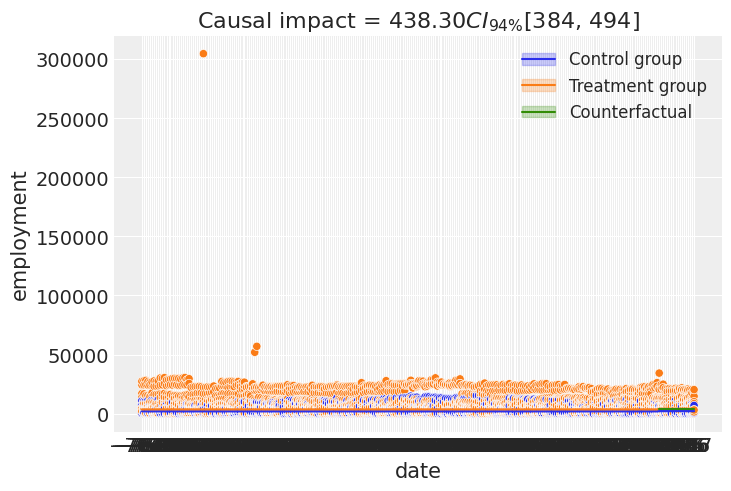

In [9]:
fig, ax = result.plot(round_to=3)

In [10]:
plt.savefig("test.png")

<Figure size 720x480 with 0 Axes>